# Supp. Data Table
Summarize all original data into useful summary statistics.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from os.path import exists, join
import seaborn as sns
import dask
import xarray as xr
import admix
from scipy.stats import norm
import seaborn as sns


import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
def read_rls(filename):
    """
    From the list of strings, convert to the estimate and varcov matrix 
    """
    with open(filename) as f:
        txt = f.readlines()
        
    est = np.array([float(i) for i in txt[1].strip('[]\n ').split()])
    varcov = [float(i) for i in ''.join(txt[3:]).replace('[', '').replace(']', '').replace('\n', '').split()]
    varcov = np.array(varcov).reshape(3, 3)
    return est, varcov

In [10]:
dict_rls = dict()
for n_indiv in [5000, 10000, 20000]:
    for anc_prop in [0.5, 0.2]:
        for cor in [0.5, 0.8, 1.0]:
            dict_rls[(n_indiv, anc_prop, cor)] = []
            for i_sim in range(50):
                filename = f"../01_simulate/out/OLD_estimate/n_indiv_{n_indiv}_anc_prop_{anc_prop}/cor_{cor}/HE.{i_sim}.txt"
                if not exists(filename):
                    continue
                dict_rls[(n_indiv, anc_prop, cor)].append(read_rls(filename))

In [11]:
for n_indiv in [5000, 10000, 20000]:
    for anc_prop in [0.5, 0.2]:
        for cor in [0.5, 0.8, 1.0]:
            rls = dict_rls[(n_indiv, anc_prop, cor)]
            est = [r[0] for r in rls]
            varcov = [r[1] for r in rls]
            est_varcov = np.cov(np.array(est).T)
            mean_varcov = np.mean(varcov, axis=0)
            print(n_indiv, anc_prop, cor)
            print("Empirical:")
            print(est_varcov)
            print("Analytical:")
            print(mean_varcov)

5000 0.5 0.5
Empirical:
[[ 6.27270635e-03  1.20556082e-03 -1.20339218e-03]
 [ 1.20556082e-03  7.35830733e-03  3.54640601e-05]
 [-1.20339218e-03  3.54640601e-05  8.08911239e-04]]
Analytical:
[[ 9.00906313e-03  2.32295744e-03 -1.90766975e-03]
 [ 2.32295744e-03  9.40883778e-03 -8.14742466e-05]
 [-1.90766975e-03 -8.14742466e-05  1.03839247e-03]]
5000 0.5 0.8
Empirical:
[[ 0.00608299  0.00258617 -0.00133017]
 [ 0.00258617  0.00777849  0.0003505 ]
 [-0.00133017  0.0003505   0.00094876]]
Analytical:
[[ 0.00937557  0.00368376 -0.00196526]
 [ 0.00368376  0.00997876 -0.00012927]
 [-0.00196526 -0.00012927  0.00105802]]
5000 0.5 1.0
Empirical:
[[ 4.99540913e-03  3.56258922e-03 -7.77627036e-04]
 [ 3.56258922e-03  9.15468947e-03  8.07820141e-05]
 [-7.77627036e-04  8.07820141e-05  7.18326230e-04]]
Analytical:
[[ 0.00965377  0.00464725 -0.00201272]
 [ 0.00464725  0.01047043 -0.00016182]
 [-0.00201272 -0.00016182  0.00107992]]
5000 0.2 0.5
Empirical:
[[ 6.46752156e-03 -1.69740743e-05 -1.16981782e-03]
 

In [5]:
# Evaluate hypothesis testing
df_plot = []
for n_indiv in [5000, 10000, 20000]:
    for anc_prop in [0.5, 0.2]:
        for cor in [0.5, 0.8, 1.0]:
            rls = dict_rls[(n_indiv, anc_prop, cor)]
            est = [r[0][1] for r in rls]
            var = [r[1][1,1] for r in rls]
            reject = [(e + np.sqrt(v) * norm.ppf(.95)) < 1.0 for e, v in zip(est, var)]
            df_plot.append((n_indiv, anc_prop, cor, np.mean(reject)))
df_plot = pd.DataFrame(df_plot, columns=["n_indiv", "anc_prop", "cor", "pr_reject"])
df_plot["n_indiv"] = df_plot["n_indiv"].astype("str")

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

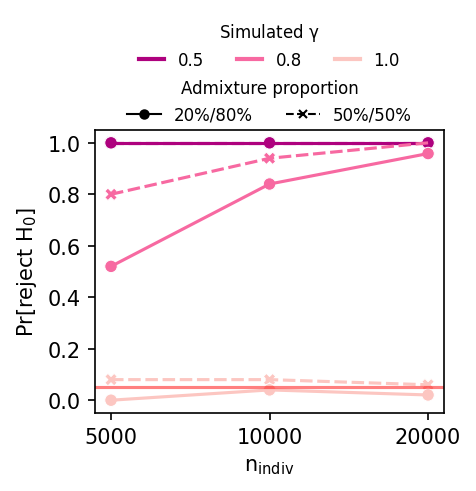

In [8]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
cmap = sns.color_palette("RdPu_r", 3)
sns.lineplot(data=df_plot, x="n_indiv", y="pr_reject", hue="cor", palette=cmap, style="anc_prop", ax=ax, alpha=1.0, legend=False)
sns.scatterplot(data=df_plot, x="n_indiv", y="pr_reject", hue="cor", palette=cmap, style="anc_prop", legend=False, ax=ax)
plt.axhline(0.05, color='r', alpha=0.5)
plt.xlabel("$n_{indiv}$")
plt.ylabel("Pr[reject $H_0$]")

# adding legends
legend_lines = [Line2D([0], [0], color=cmap[0], lw=2),
                Line2D([0], [0], color=cmap[1], lw=2),
                Line2D([0], [0], color=cmap[2], lw=2)]
ax.legend(legend_lines, ['0.5', '0.8', '1.0'], bbox_to_anchor=[0.5, 1.3], 
           loc='center', title="Simulated $\gamma$", fontsize=8, title_fontsize=8, frameon=False, ncol=3, handlelength=1.5)

legend_markers = [Line2D([0,1],[0,1], color='k', marker='o', markersize=4, linestyle='-', lw=1),
                Line2D([0], [0], color='k', marker='x', markersize=4, linestyle='--', lw=1)]
from matplotlib.legend import Legend
leg = Legend(ax, legend_markers, ['20%/80%', '50%/50%'], bbox_to_anchor=[0.5, 1.1],
             loc='center', title="Admixture proportion", frameon=False, ncol=2, fontsize=8, title_fontsize=8,)
ax.add_artist(leg)
# plt.savefig("power.pdf", bbox_inches='tight', dpi=150)